<img src="Assets/header.png" style="width: 800px;">

# `Contents:`

- [Load Libraries](#load)
- [Data Preparation](#DataPreparation)
    
- [Setting up the pre-processor](#PreProcessor)

- [Keyword Analysis](#KeywordAnalysis)    
	- [Vectorising the data (Term-Frequency Inverse Document Frequency)](#TFIDF)    
	- [Visualising weighted word counts in Tableau](#tab)            
- [Modelling](#Modelling)
	- [Model Initialisation & Hyperparameters](#modelint)
	- [Helper functions](#helper)   
	- [Fitting the models](#fitting)   
- [Evaluation of model performance & Interpretation](#evaluation)       
	- [Coefficients](#coefficients) 
- [Using a voting classifier to improve scores](#voting)       
- [Setting up a Pipeline](#pipeline)       
	 - [Applying the model on new and unseen data](#unseen) 
	 - [Evaluating the final model - confusion matrices / classifications report](#finalconfusion)
	 - [Evaluating the final model - ROC](#roc)        

<a id="load"></a>
# `Load Libraries`
---

In [1]:
import numpy as np
import pandas as pd
import time
import ast
import matplotlib.pyplot as plt
import regex as re
from functools import reduce

#viz
from wordcloud import WordCloud
import seaborn as sns


#data prep / scaling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as esw

#models
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

#model selection and tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


#evaluation 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report



#look & feel
sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('./Clean_Data_Eng/Final_merged_Eng.csv')
df.dropna(inplace=True)

<a id="DataPreparation"></a>
# `Data Preparation`
---

The aim of this project is to see if brands are doing enough to differentiate their social content on Facebook. However it became apparent that many posts were littered with quite obvious branding cues (see screengrabs below) that would make it too easy for a machine to learn the difference between them. 

Ultimately, I wanted to get to the point where I was only using the narrative of the post i.e keeping all the words and content that related to topics and 'tone of voice' but removing as many 'obvious' branding cues as possible. This was achieved through a range of regular expressions and string formatting - the main principles being:

    1) Remove as many direct branding cues as possible  
    2) Remove as many links and hashtags as possible (indirect branding cues)
    3) Leave the narrative / content
   

## Examples of posts with branding cues we want to get rid of

<img src="Assets/Waitrose_cues.png" style="width: 500px;">

<img src="Assets/Lidl_cues.png" style="width: 500px;">

The diagram below summarises some examples of these transformations.

<img src="Assets/Dataprep.jpg">


In [3]:
#Selection of Regex functions that clean the post content of links and hashtags
def nohash(x):
    return re.sub(r'#\S+', '',x)
def nohttp(x):
    return re.sub(r'http\S+', '',x)
def nobitly(x):
    return re.sub(r'bit.ly\S+', '',x)
def nolink(x):
    return re.sub(r'\b\w*[/.]\w*\b','',x)
def cleaner(x):
    return nohash(nohttp(nobitly(nolink(x))))

brand_cues =  ['\n','Terms:' ,'See More', 'store','stores',
             'Sainsburys',"Sainsbury’s",'sainsburys',"sainsbury’s",'sainsbury','Sainsbury','nectar','Nectar','Good Living','Tu','tu',
             'Tesco','tesco',"Tesco's",'clubcard','Clubcard','Tesco Extra','Jamie','Jamie Oliver',
             'Waitrose','waitrose','heston','Heston',
             'Lidl','LidlUk','lidl',"lidl's",'lidluk',
             'Heidi','heidi','klum','Klum',
             'Morrisons','morrisons','msstorefinder','nutmeg','Nutmeg',
             'ASDA','asda','Asda','bestchristmasever','George',
             'M&S','MnS','Marks & Spencer','Marks&Spencer','marks and spencer','marksandspencer','marks&spencer'] 

#Function that removes any obvious branding cues (above) from the post content i.e. brand names, celebrities
def debrander(x):
    x = re.sub(r'[,.!]',' ',x).split()
    for word in x:
        if word in brand_cues:
            x.remove(word)
    x = [' {} '.format(elem) for elem in x]
    return ''.join(x) 

<a id="PreProcessor"></a>
# `Setting up the pre-processor`
---

The pre-processor has a chain of events utilising some of the above functions. The aim will be to incorporate this into the model pipeline later on once we have our best model.

### Future Proofing 
  
In theory if we were to scrape more social content from any other page on Facebook and run a similar classification stufy, we could re-use this pre-processor for that data too. Obviously the brand_cues list we use to 'clean' the data of its branding would need to be updated however there is the opportunity to repeat this processing on other similarly structured data if needed.

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
class ContentPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, cleaner=None,debrander=None,columns_to_drop=None,):
        self.cleaner = cleaner
        self.debrander = debrander
        self.columns_to_drop = columns_to_drop
       
    #function as outlined above
    def _cleaner(self, X):
        try:
            for col in self.cleaner:
                try:
                    subset = X.loc[:,col]
                    subset = subset.apply(cleaner) 
                    X[col] = subset
                except:
                    pass
        except:
            pass
        return X
    
    #function as outlined above
    def _debrander(self, X):
        try:
            for col in self.debrander:
                try:
                    subset = X.loc[:,col]
                    subset = subset.apply(debrander) 
                    X[col] = subset
                except:
                    pass
        except:
            pass
        return X
    
    #drops any unwanted columns
    def _drop_unused_cols(self, X):
        for col in self.columns_to_drop:
            try:
                X = X.drop(col, axis=1)
            except:
                pass
        return X

    def transform(self, X, *args):
        X = self._cleaner(X)
        X = self._debrander(X)
        X = self._drop_unused_cols(X)
        return X

    def fit(self, X,*args):
        return self

In [5]:
#set up an instance of our preprocessor class
ContentPrep = ContentPreprocessor(cleaner=['Post_Content'],debrander=['Post_Content'],
                                  columns_to_drop=['Date','Year','All_Responses', 'Comments', 'Shares', 'Views', 'Contains_Link', 'Contains_Video', 'Has_Hashtag', 'Hashtag_Count', 'Likes', 'Response_Rate', 'Comments_Rate', 'Shares_Rate', 'Video_Rate'])

In [6]:
#before...too many brand cues
df.Post_Content[2417]

'A celebratory half term sweet treat is in order. Why not follow these simple steps to make a macaron even more delectable by turning it into an ice cream sandwich? http://tes.co/IceCreamMacarons'

In [7]:
#before...too many brand cues
df.Post_Content[3451]

'Richard Pearson on a farm visit with Phil Twizzell, one of our key free range egg suppliers po.st/MFarm24 #farm24 #morrisonsfarmers #realfarmers #hens #freerangehens #farmer\n#farming'

In [8]:
#after...better
ContentPrep.transform(df).Post_Content[2417]

' A  celebratory  half  term  sweet  treat  is  in  order  Why  not  follow  these  simple  steps  to  make  a  macaron  even  more  delectable  by  turning  it  into  an  ice  cream  sandwich? '

In [9]:
#after...better
ContentPrep.transform(df).Post_Content[3451]

' Richard  Pearson  on  a  farm  visit  with  Phil  Twizzell  one  of  our  key  free  range  egg  suppliers '

In [10]:
#setting the target
y = ContentPrep.transform(df).Brand

In [11]:
#setting the predictor
X = ContentPrep.transform(df).Post_Content

In [12]:
#coding the brands as integers
y.replace({'Sainsburys': 0, 'Tesco': 1, 'Waitrose': 2, 
                'Lidl': 3,'Marks and Spencer' : 4,'Morrisons' : 5,'ASDA': 6},inplace = True)     
#string labels for later on
y_labels = ["Sainsbury's",'Tesco','Waitrose','Lidl','M&S','Morrisons','ASDA']  

<a id="KeywordAnalysis"></a>
# `Keyword Analysis`



In [13]:
# count word appearances
def word_counter(mat):
    count = np.array(mat.sum(axis=0))[0]
    return count

# sort words by frequency
from operator import itemgetter

def word_frequency_sorter(words,counts):
    sort_result = sorted(zip(words,list(counts)),key=itemgetter(1),reverse=True)
    return sort_result

<a id="TFIDF"></a>
## `Vectorising the data (Term-Frequency Inverse Document Frequency)`


In [14]:
#adding the brand cues from above to the stop word set just to cover any instance where the 
#regex and string formatting didn't catch everything
stopWords = set(list(esw)).union(set(brand_cues))

In [15]:
#Instantiating an instance of a term-frequency inverse document frequency vectoriser on all of our data with 
#bepoke stop word list
tvec = TfidfVectorizer(stop_words=stopWords,
                       sublinear_tf=True,
                        max_df=0.25)
tvec.fit(X)
tvec_mat = tvec.transform(X)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['extra', 'george', 'good', 'jamie', 'living', 'marks', 'mns', 'oliver', 'spencer', 'terms'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [16]:
#let's have a look at the words with their weights
all_words = pd.DataFrame(word_frequency_sorter(tvec.get_feature_names(),word_counter(tvec_mat)))
all_words.columns = ['Word','Total Frequency']
all_words.head(20)

,Word,Total Frequency
0,recipe,133.951644
1,christmas,108.869394
2,new,94.003739
3,day,91.687901
4,just,85.234843
5,make,84.854196
6,delicious,69.666826
7,range,64.303157
8,ve,61.731456
9,perfect,61.453317


In [17]:
#TEMP
df_word_frequency = {}

csum_i = word_counter(tvec_mat[np.array(y)==6,:])
df_word_frequency[6] = pd.DataFrame(word_frequency_sorter(tvec.get_feature_names(),csum_i),columns=['word','frequency'])
df_word_frequency[6].set_index('word',inplace=True)

frame = pd.DataFrame(df_word_frequency[6].head(20))
frame.to_csv('asda')



In [17]:
#exploring top words by the different classes
df_word_frequency = {}
for i in range(7):
    csum_i = word_counter(tvec_mat[np.array(y)==i,:])
    df_word_frequency[i] = pd.DataFrame(word_frequency_sorter(tvec.get_feature_names(),csum_i),columns=['word','frequency'])
    df_word_frequency[i].set_index('word',inplace=True)
    print(y_labels[i])
    print(df_word_frequency[i].head(20))
    print()



Sainsbury's
           frequency
word                
magazine   50.479341
recipe     47.565382
cake       12.458966
new        11.616688
chocolate   9.903146
dinner      9.524604
make        9.471327
love        8.212003
want        7.932704
ve          7.789387
cheese      7.766964
recipes     7.563144
ll          7.419630
issue       7.380278
vegan       7.379307
chicken     6.868942
leftover    6.545710
got         6.369777
right       6.255216
christmas   6.235263

Tesco
           frequency
word                
christmas  22.989491
make       22.024989
delicious  17.340786
day        16.944848
recipes    16.331308
just       15.112308
easy       13.542029
ve         11.923733
festive    11.712612
little     11.626627
family     11.481512
need       11.426322
weekend    11.396564
online     11.300033
summer     11.113828
finest     10.975466
party      10.902864
sweet      10.394475
time       10.351245
week       10.278266

Waitrose
           frequency
word                
recip

<a id="tab"></a>
## `Visualising weighted word counts in Tableau`

<img src="Assets/Tableau Output/sains_final.png">

<img src="Assets/Tableau Output/asda_final.png">

<img src="Assets/Tableau Output/mns_final.png">

<img src="Assets/Tableau Output/lidl_final.png">

<img src="Assets/Tableau Output/tesco_final.png">

<img src="Assets/Tableau Output/waitrose_final.png">

<a id="Modelling"></a>
# `Modelling`
---

## Our baseline is the dominant class - Lidl, in which case it's 21%

In [20]:
ContentPrep.transform(df).Brand.value_counts(normalize=True)

Lidl                 0.213071
Tesco                0.168189
Marks and Spencer    0.137008
Morrisons            0.125669
Waitrose             0.122362
ASDA                 0.121260
Sainsburys           0.112441
Name: Brand, dtype: float64

## Setting up the train and test splits

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100,stratify=y, shuffle=True, test_size=0.25)

<a id="modelint"></a>
## `Model Initialisation & Hyperparameters`
---

In [23]:
#adding the brand cues from above to the stop word set just to cover any instance where the 
#regex and string formatting didn't catch everything
stopWords = set(list(esw)).union(set(brand_cues))

In [24]:
tvec = TfidfVectorizer(stop_words=stopWords,
                       sublinear_tf=True,
                        max_df=0.25)
tvec.fit(X_train)
tvec_mat = tvec.transform(X_train)

X_train = tvec_mat
X_test = tvec.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['extra', 'george', 'good', 'jamie', 'living', 'marks', 'mns', 'oliver', 'spencer', 'terms'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Five classifiers were chosen and a pre-defined set of hyperparameters were to be used in a cross validated grid search

In [25]:
model_lr = LogisticRegression()
#Logistic Regression Parameters
penalty = ['l1','l2']
solver = ['liblinear']
C = np.logspace(-4, 5, 400)
# Create LR hyperparameter frame
params_lr = dict(penalty=penalty, solver=solver,C=C)

model_knn = KNeighborsClassifier()
#KNN Parameters
n_neighbors = list(range(1,21,3))
weights = ['distance','uniform']
algorithm = ['ball_tree','kd_tree', 'brute']
# Create KNN hyperparameter frame
params_knn = dict(n_neighbors=n_neighbors, weights=weights,algorithm=algorithm)

model_svm = SVC()
#SVM Parameters
kernel = ['rbf', 'linear','sigmoid','poly']
gamma = np.logspace(0.001, 1, 5)
C = np.linspace(0.001, 1, 5)
# Create SVM hyperparameter frame
params_svm = dict(gamma=gamma, kernel=kernel,C=C)

model_rf = RandomForestClassifier()
#RF Parameters
bootstrap = [True]
max_depth = [5,10,15,30,50,80, 90, 100, 200]
min_samples_leaf = [3, 4, 5]
min_samples_split = [8, 10, 12]
n_estimators = [100, 200, 300,500, 1000]
# Create RF hyperparameter frame
params_rf= dict(max_depth = max_depth,min_samples_leaf = min_samples_leaf,
n_estimators=n_estimators)

model_mlp = MLPClassifier()
#MLP Parameters
solver = ['lbfgs','adam']
alpha = np.linspace(0.001, 1, 5)
hidden_layer_sizes = [2,4,6,8,10,12,14,16]
activation = ['relu']
batch_size=['auto']

# Create MLP hyperparameter frame
params_mlp= dict(alpha=alpha,solver=solver,hidden_layer_sizes=hidden_layer_sizes,activation=activation,batch_size=batch_size)



<a id="helper"></a>
## `Helper functions`
---

In [26]:
#function that returns a confusion matrix
def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is not None:
        cols = ['p_'+c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['p_'+str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df  

#function that takes a model, its hyperparameters and runs a grid search on that model returning the best score on the test data
#the best parameters, a confusion matrix and a classification report
def model_gs(estimator, params, X_train, y_train, X_test, y_test, scoring_function=metrics.accuracy_score, scoring='accuracy',cv=5):
    gs = GridSearchCV(estimator=estimator,param_grid=params,return_train_score=True,scoring=scoring,cv=cv,verbose=1,n_jobs=-1)
    gs.fit(X_train, y_train)

    print("Best score")
    print(gs.best_score_)
    print()
    print("Best estimator")

    print(gs.best_estimator_.get_params())
    print()

    predictions = gs.best_estimator_.predict(X_test)
    print('Test score: ', scoring_function(y_test, predictions))
    print()
    
    #classification report
    clf_rep = metrics.precision_recall_fscore_support(y_test, gs.predict(X_test))
    out_dict = {
             "precision" :clf_rep[0].round(2)
            ,"recall" : clf_rep[1].round(2)
            ,"f1-score" : clf_rep[2].round(2)
            ,"support" : clf_rep[3]
            }
    out_df = pd.DataFrame(out_dict, index = y_labels)
    avg_tot = (out_df.apply(lambda x: round(x.mean(), 2) if x.name!="support" else  round(x.sum(), 2)).to_frame().T)
    avg_tot.index = ["avg/total"]
    out_df = out_df.append(avg_tot)
    print(out_df)

    return docm(y_test,predictions,labels=y_labels) 

<a id="fitting"></a>
# `Fitting the models`
---

In [27]:
#Grid searched, cross validated Logistic Regression
model_gs(model_lr,params_lr,X_train, y_train, X_test, y_test,
                          scoring_function=metrics.accuracy_score,
                          scoring='accuracy')


Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 2229 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2579 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 3029 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 3579 tasks      | elapsed:  6.6min


Best score
0.6751364972700546

Best estimator
{'C': 10.717048298967093, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Test score:  0.6926952141057935

             precision  recall  f1-score  support
Sainsbury's       0.78    0.63      0.70    178.0
Tesco             0.57    0.62      0.59    267.0
Waitrose          0.82    0.77      0.79    194.0
Lidl              0.69    0.75      0.71    338.0
M&S               0.60    0.62      0.61    218.0
Morrisons         0.75    0.76      0.76    200.0
ASDA              0.76    0.69      0.72    193.0
avg/total         0.71    0.69      0.70   1588.0


[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  7.1min finished
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


,p_Sainsbury's,p_Tesco,p_Waitrose,p_Lidl,p_M&S,p_Morrisons,p_ASDA
Sainsbury's,112,14,7,25,13,6,1
Tesco,10,165,10,36,25,9,12
Waitrose,4,16,149,11,7,6,1
Lidl,9,32,7,252,24,4,10
M&S,6,25,4,24,136,14,9
Morrisons,0,16,3,9,10,152,10
ASDA,2,23,2,10,11,11,134


In [85]:
#Grid searched, cross validated K Nearest Neighboure
model_gs(model_knn,params_knn,X_train, y_train, X_test, y_test,
                          scoring_function=metrics.accuracy_score,
                          scoring='accuracy')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   44.7s finished


Best score
0.5052498950020999

Best estimator
{'algorithm': 'ball_tree', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 19, 'p': 2, 'weights': 'uniform'}

Test score:  0.47103274559193953

             precision  recall  f1-score  support
Sainsbury's       0.72    0.24      0.36    178.0
Tesco             0.29    0.76      0.42    267.0
Waitrose          0.96    0.33      0.49    194.0
Lidl              0.83    0.39      0.53    338.0
M&S               0.75    0.40      0.52    218.0
Morrisons         0.37    0.79      0.51    200.0
ASDA              0.92    0.32      0.47    193.0
avg/total         0.69    0.46      0.47   1588.0


,p_Sainsbury's,p_Tesco,p_Waitrose,p_Lidl,p_M&S,p_Morrisons,p_ASDA
Sainsbury's,43,87,2,5,5,35,1
Tesco,3,203,0,4,4,53,0
Waitrose,4,97,64,4,0,25,0
Lidl,7,136,1,131,11,52,0
M&S,2,74,0,8,88,46,0
Morrisons,1,32,0,3,2,158,4
ASDA,0,67,0,2,8,55,61


In [86]:
#Grid searched, cross validated Random Forest
model_gs(model_rf,params_rf,X_train, y_train, X_test, y_test,
                          scoring_function=metrics.accuracy_score,
                          scoring='accuracy')

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed: 27.8min finished


Best score
0.6138177236455271

Best estimator
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 200, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Test score:  0.6164987405541562

             precision  recall  f1-score  support
Sainsbury's       0.83    0.60      0.70    178.0
Tesco             0.51    0.54      0.52    267.0
Waitrose          0.73    0.62      0.67    194.0
Lidl              0.56    0.73      0.63    338.0
M&S               0.58    0.53      0.56    218.0
Morrisons         0.62    0.61      0.62    200.0
ASDA              0.71    0.63      0.67    193.0
avg/total         0.65    0.61      0.62   1588.0


,p_Sainsbury's,p_Tesco,p_Waitrose,p_Lidl,p_M&S,p_Morrisons,p_ASDA
Sainsbury's,107,13,5,33,9,7,4
Tesco,5,145,10,52,23,18,14
Waitrose,5,28,121,16,11,8,5
Lidl,8,40,7,246,19,9,9
M&S,1,27,7,39,116,20,8
Morrisons,0,17,8,33,11,122,9
ASDA,3,16,7,23,10,12,122


In [87]:
#Grid searched, cross validated support vector
model_gs(model_svm,params_svm,X_train, y_train, X_test, y_test,
                          scoring_function=metrics.accuracy_score,
                          scoring='accuracy')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.4min finished


Best score
0.6604367912641748

Best estimator
{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1.0023052380778996, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Test score:  0.6908060453400504

             precision  recall  f1-score  support
Sainsbury's       0.78    0.63      0.70    178.0
Tesco             0.53    0.69      0.60    267.0
Waitrose          0.82    0.73      0.77    194.0
Lidl              0.69    0.74      0.72    338.0
M&S               0.63    0.64      0.64    218.0
Morrisons         0.78    0.70      0.73    200.0
ASDA              0.81    0.67      0.73    193.0
avg/total         0.72    0.69      0.70   1588.0


,p_Sainsbury's,p_Tesco,p_Waitrose,p_Lidl,p_M&S,p_Morrisons,p_ASDA
Sainsbury's,112,25,6,20,7,6,2
Tesco,9,184,10,34,18,4,8
Waitrose,3,21,142,12,9,5,2
Lidl,11,41,7,250,19,2,8
M&S,4,33,3,23,140,13,2
Morrisons,0,21,4,13,14,139,9
ASDA,4,25,2,8,14,10,130


In [90]:
#Grid searched, cross validated Logistic Regression
model_gs(model_mlp,params_mlp,X_train, y_train, X_test, y_test,
                          scoring_function=metrics.accuracy_score,
                          scoring='accuracy')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 15.9min finished


Best score
0.6671566568668627

Best estimator
{'activation': 'relu', 'alpha': 0.25075, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': 16, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}

Test score:  0.6939546599496221

             precision  recall  f1-score  support
Sainsbury's       0.78    0.65      0.71    178.0
Tesco             0.57    0.63      0.60    267.0
Waitrose          0.82    0.75      0.78    194.0
Lidl              0.69    0.73      0.71    338.0
M&S               0.61    0.65      0.63    218.0
Morrisons         0.75    0.75      0.75    200.0
ASDA              0.76    0.69      0.72    193.0
avg/total         0.71    0.69      0.70   1588.0


,p_Sainsbury's,p_Tesco,p_Waitrose,p_Lidl,p_M&S,p_Morrisons,p_ASDA
Sainsbury's,115,12,6,22,15,7,1
Tesco,11,169,9,34,23,10,11
Waitrose,4,16,145,12,9,6,2
Lidl,9,35,6,248,23,5,12
M&S,5,23,5,25,141,12,7
Morrisons,0,16,3,10,11,150,10
ASDA,3,24,2,10,10,10,134


<a id="evaluation"></a>
# `Evaluation of model performance`
---

In [126]:
score_summary = pd.DataFrame({'LogisticRegression' : [0.6926952141057935,0.71,0.69],'KNN' :[ 0.47103274559193953,0.69,0.46],
                                 'SVM':[0.6908060453400504,0.72,0.69],'RandomForestClassifier':[0.6164987405541562,0.65,0.61],
                                'Multi-Layer Perceptron':[0.6919546599496221,0.71,0.69]})

In [127]:
score_summary.index = ['Accuracy', 'Precision', 'Recall']
score_summary = score_summary.T

# Logistic Regression is our winner here - achieving 0.6926 accuracy, which is better than our baseline of 0.21

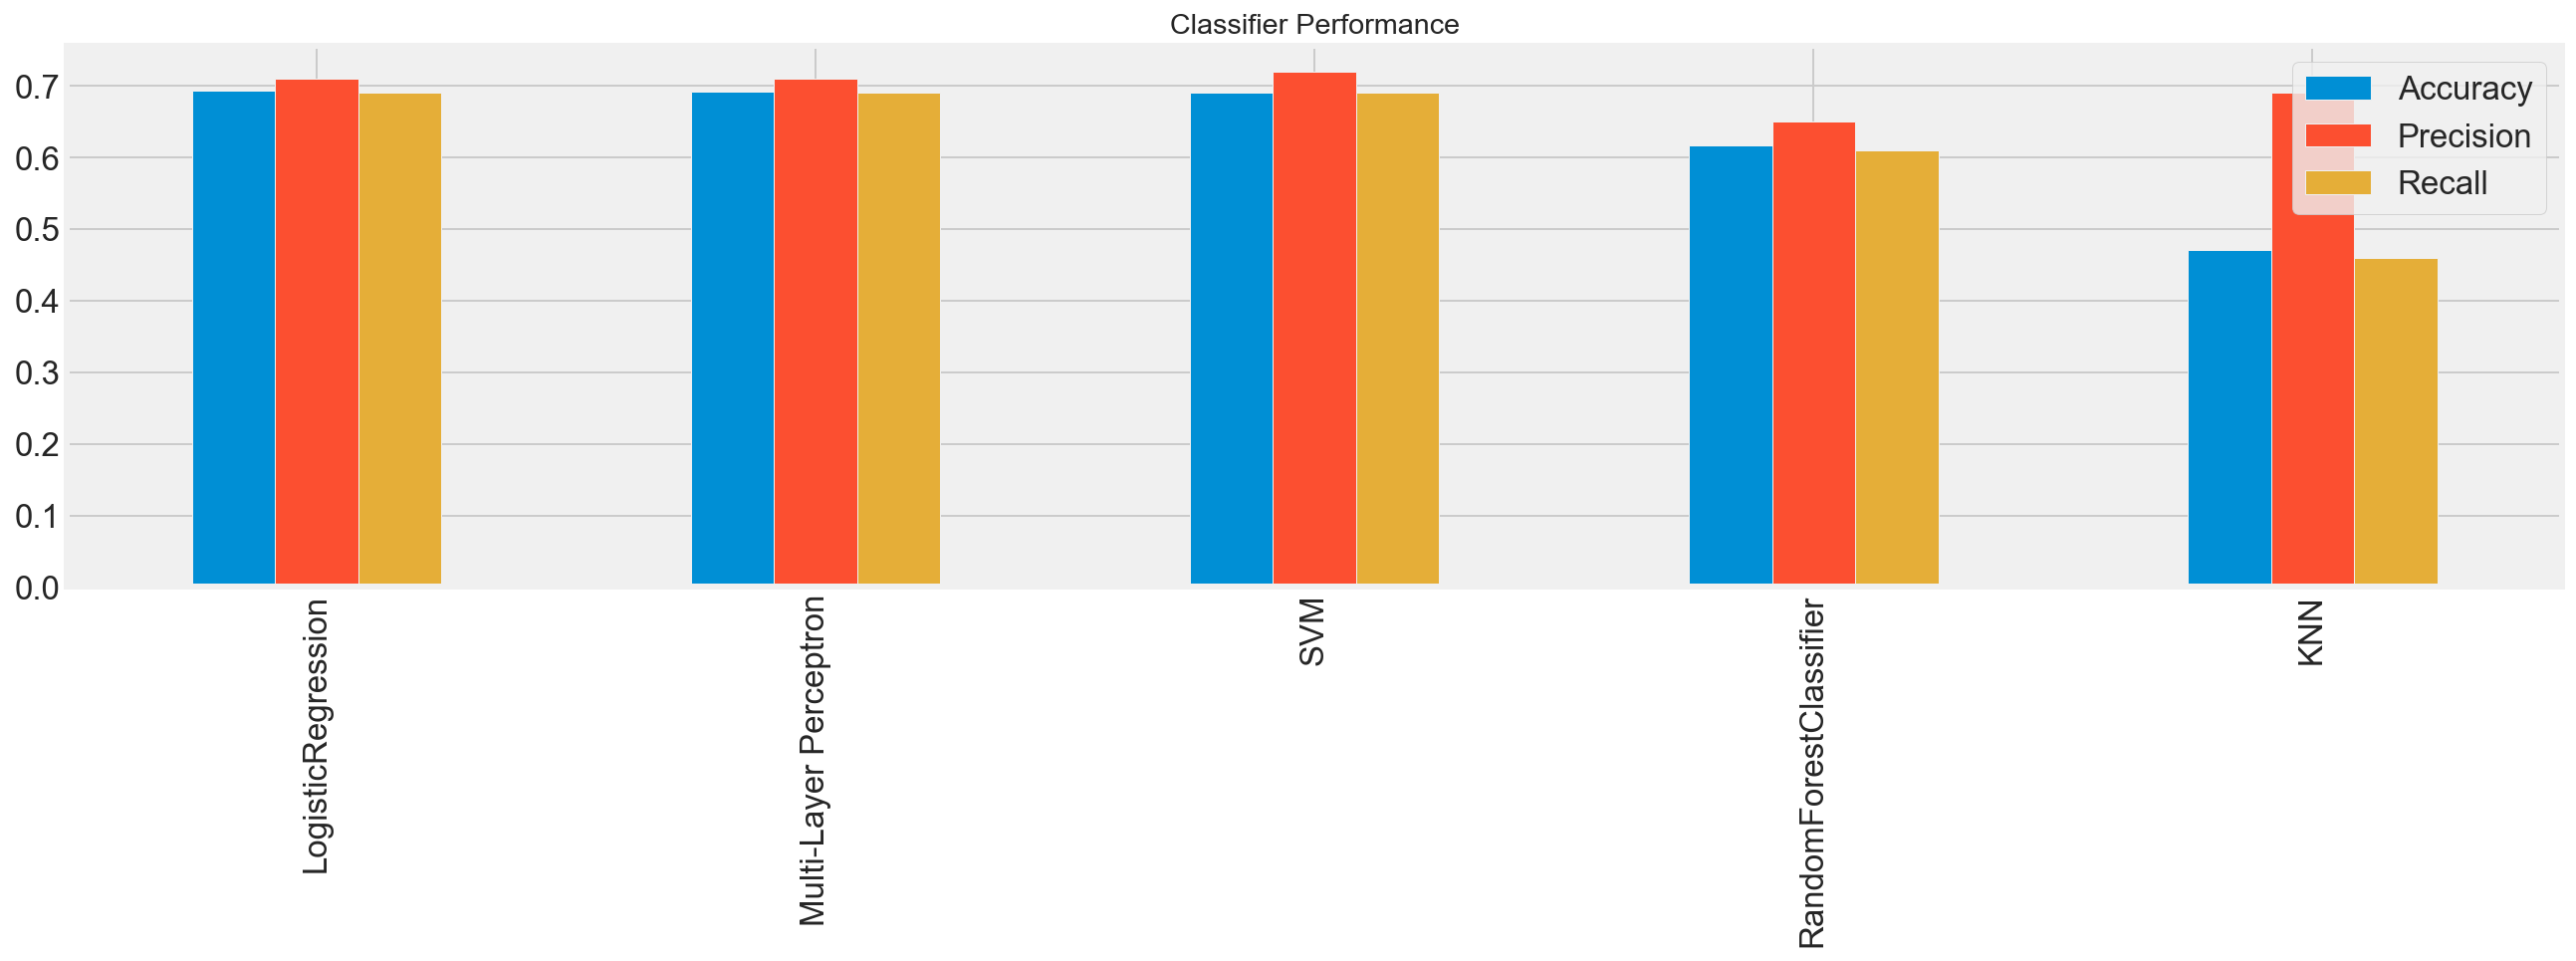

In [129]:
score_summary.sort_values(by='Accuracy',ascending=False).plot(kind='bar',figsize=(20,5),legend=True,title='Classifier Performance')
plt.show()

<a id="coefficients"></a>
## `Coefficients`

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100,stratify=y, shuffle=True, test_size=0.25)


In [22]:

tvec = TfidfVectorizer(stop_words=stopWords,
                       sublinear_tf=True,
                        max_df=0.25)
tvec.fit(X_train)
tvec_mat = tvec.transform(X_train)

X_train = tvec_mat
X_test = tvec.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['extra', 'george', 'good', 'jamie', 'living', 'marks', 'mns', 'oliver', 'spencer', 'terms'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [23]:
#the strongest model from before with its relevant parameters
LR = LogisticRegression(penalty='l2', solver = 'liblinear', C=10.717048298967093)

In [24]:
LR.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=10.717048298967093, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [25]:
#function that takes a brand and returns a defined top n of coefficients
def co_eff(brand,length):
    
    brand_dic_colours = {'Sainsburys':'#ED8B01','Lidl':'#015AA2',
                    'Tesco':"#EE1C2E",'Morrisons':'#ffe900',
                    'Marks and Spencer':'#00110A','Waitrose':'#7BB135',
                    'ASDA':'#00FF00'}

    brand_dic = {'Sainsburys': 0, 'Tesco': 1, 'Waitrose': 2, 
                'Lidl': 3,'Marks and Spencer' : 4,'Morrisons' : 5,'ASDA': 6}
                      
    coefs_vars_lr = pd.DataFrame({'coef': LR.coef_[brand_dic[brand]],'feature': tvec.get_feature_names(),'abscoef': np.abs(LR.coef_[brand_dic[brand]])})
    edited = coefs_vars_lr.sort_values(by='abscoef',ascending=False).head(length)
    
    title = '{} - Top 10 Co-Efficients Influencing Class Allocation'.format(brand)
    
    edited.plot(kind='barh',x='feature',y='coef',color=brand_dic_colours[brand],figsize=(5,5),title=title)
    return plt.show()

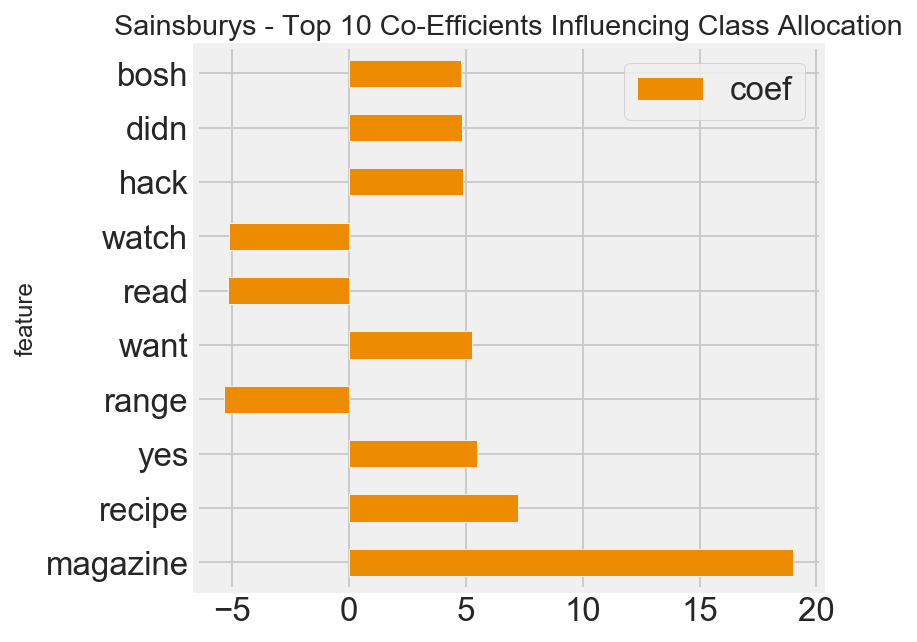

In [26]:
co_eff('Sainsburys',10)

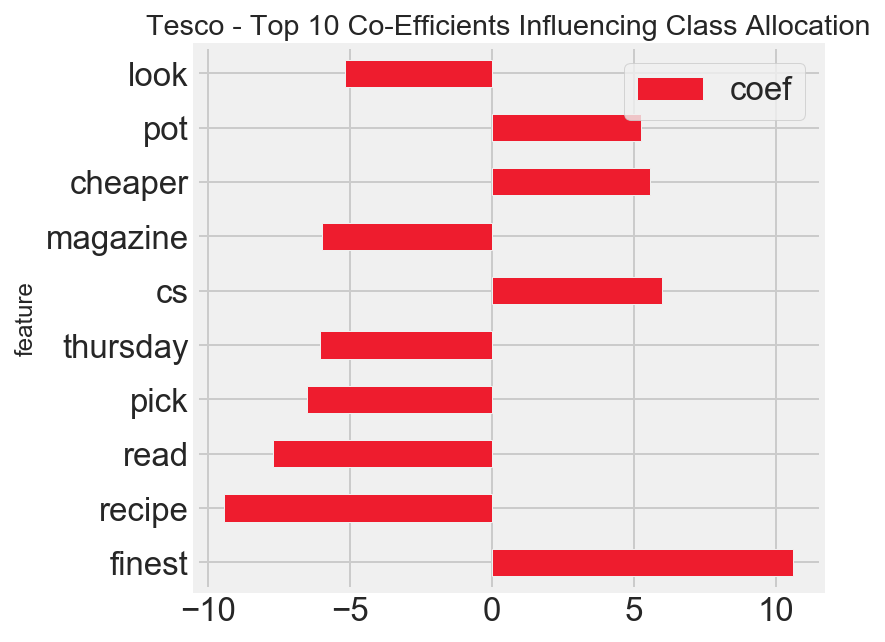

In [27]:
co_eff('Tesco',10)

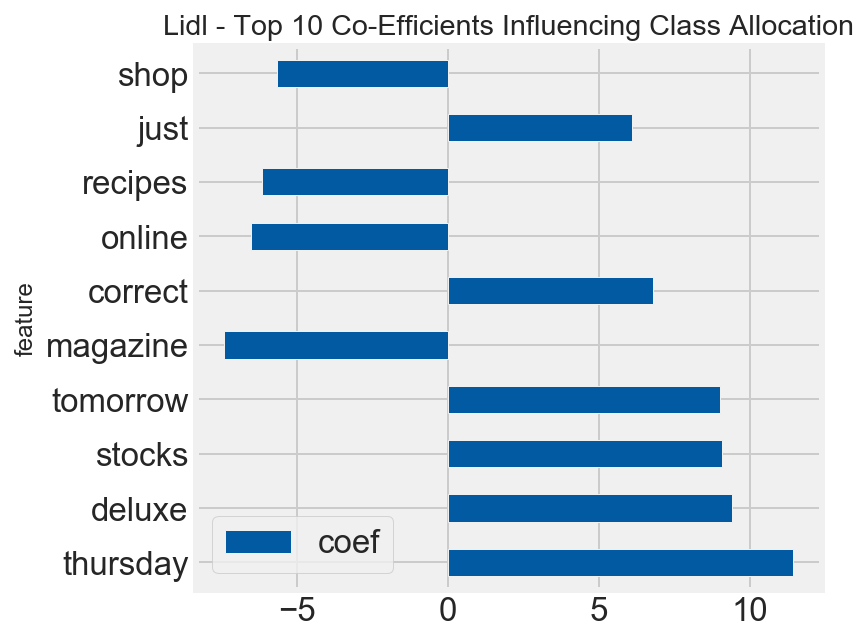

In [28]:
co_eff('Lidl',10)

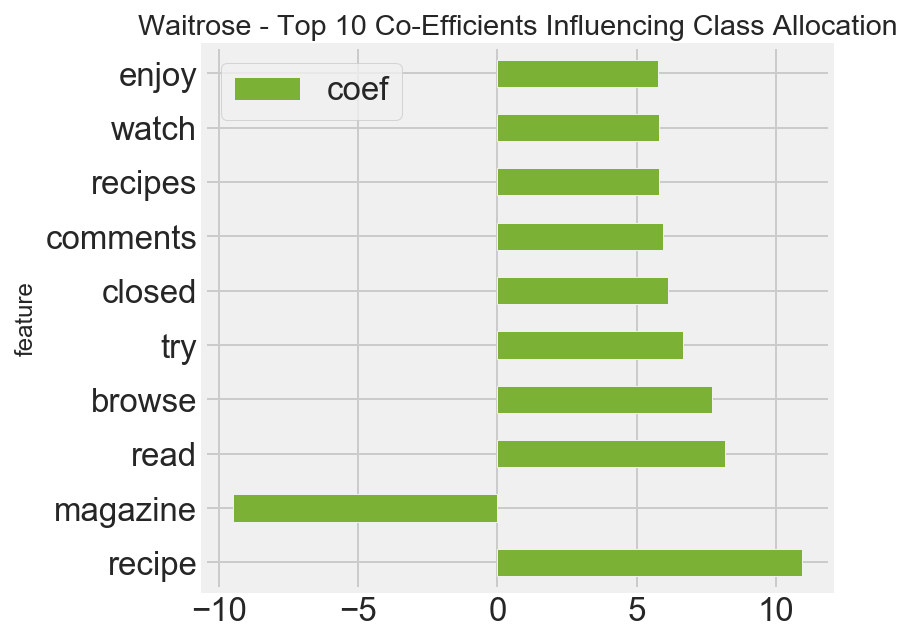

In [29]:
co_eff('Waitrose',10)

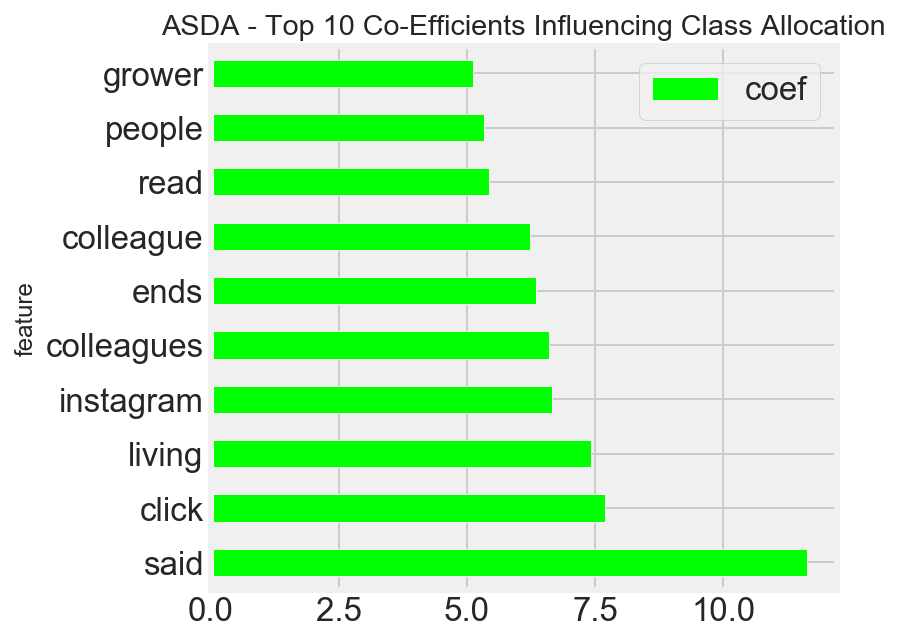

In [30]:
co_eff('ASDA',10)

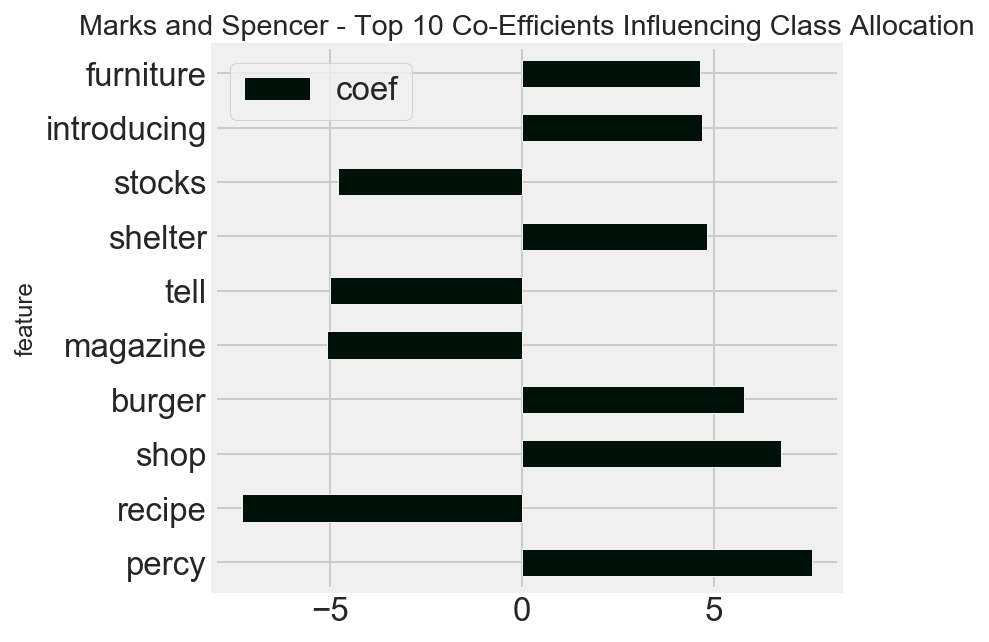

In [31]:
co_eff('Marks and Spencer',10)

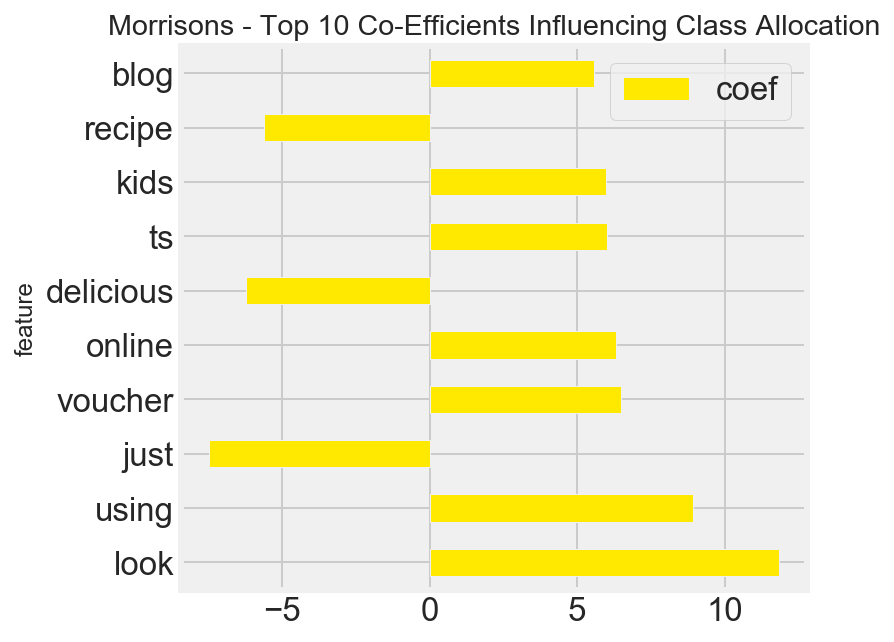

In [32]:
co_eff('Morrisons',10)

<a id="voting"></a>
# `Using a voting classifier to improve scores`
---

We can see in the many classification reports above that some models were better at classifying some labels more than others. For instance, KNN was very good at predicting Waitrose, but suffered with many others. Subsequently KNN's overall accueracy was much lower (0.471). By implementing a voting classifier we can integrate several models, leverage their individual strengths and improve our overall accuracy score.

For reference - Logistic Regression was our strongest model with 0.692 accuracy.

In [42]:
#set up train and test splits and apply the same vectorisation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100,stratify=y, shuffle=True, test_size=0.25)

tvec = TfidfVectorizer(stop_words=stopWords,
                       sublinear_tf=True,
                        max_df=0.25)
tvec.fit(X_train)
tvec_mat = tvec.transform(X_train)

X_train = tvec_mat
X_test = tvec.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['extra', 'george', 'good', 'jamie', 'living', 'marks', 'mns', 'oliver', 'spencer', 'terms'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [43]:
#implementing a voting classifier using LogisticRegression, KNN and RandomForest

from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(penalty='l2', solver = 'liblinear', C=10.717048298967093,random_state=100)
clf2 = KNeighborsClassifier(algorithm='ball_tree', leaf_size = 30, metric= 'minkowski', n_neighbors = 19, p= 2, weights= 'uniform')
clf3 = RandomForestClassifier(bootstrap = True,criterion= 'gini', max_depth = 200,  
                              min_samples_leaf = 3, min_samples_split = 2, n_estimators = 300, random_state=100)

eclf1 = VotingClassifier(estimators=[('lr', clf1), ('knn', clf2), ('rf', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
print(eclf1.predict(X_test))

eclf2 = VotingClassifier(estimators=[('lr', clf1), ('knn', clf2), ('rf', clf3)],voting='soft')
eclf2 = eclf2.fit(X_train, y_train)
print(eclf2.predict(X_test))

eclf3 = VotingClassifier(estimators=[('lr', clf1), ('knn', clf2), ('rf', clf3)],voting='soft', weights=[2,1,1],flatten_transform=True)
eclf3 = eclf3.fit(X_train, y_train)
print(eclf3.predict(X_test))



print(eclf3.transform(X_test).shape)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


[3 6 6 ... 3 4 3]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


[3 6 6 ... 3 4 3]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


[3 6 6 ... 3 4 3]
(1588, 21)


In [44]:
#excellent - we have improved our accuracy  a little with the second voting class
print("1st VC: ",eclf1.score(X_test,y_test))
print("2nd VC: ",eclf2.score(X_test,y_test))
print("3rd VC: ",eclf3.score(X_test,y_test))
print('\n')
print("Winning VC parameters: ",eclf2.get_params)


1st VC:  0.6618387909319899
2nd VC:  0.6996221662468514
3rd VC:  0.697103274559194


Winning VC parameters:  <bound method VotingClassifier.get_params of VotingClassifier(estimators=[('lr', LogisticRegression(C=10.717048298967093, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=100,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False...tors=300, n_jobs=None,
            oob_score=False, random_state=100, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)>


<a id="pipeline"></a>
# `Setting up a pipeline with our new voting classifier`
---

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100,stratify=y, shuffle=True, test_size=0.25)

In [19]:
tvec = TfidfVectorizer(stop_words=stopWords,
                       sublinear_tf=True,
                        max_df=0.25)
tvec.fit(X_train)
tvec_mat = tvec.transform(X_train)



/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['extra', 'george', 'good', 'jamie', 'living', 'marks', 'mns', 'oliver', 'spencer', 'terms'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [20]:
CP = ContentPrep
TVEC = TfidfVectorizer(stop_words=stopWords,sublinear_tf=True,max_df=0.25)
VC = eclf2
#LR = LogisticRegression(penalty='l2', solver = 'liblinear', C=10.717048298967093)

In [21]:
vc_pipe = Pipeline([
    ('content_prep', ContentPreprocessor(cleaner=['Post_Content'],
                                         debrander=['Post_Content'],
                                         columns_to_drop=['Date','Year','All_Responses', 'Comments', 'Shares', 'Views', 'Contains_Link', 'Contains_Video', 'Has_Hashtag', 'Hashtag_Count', 'Likes', 'Response_Rate', 'Comments_Rate', 'Shares_Rate', 'Video_Rate'])),
    ('tfidf_vec', TfidfVectorizer(stop_words=stopWords,
                                  sublinear_tf=True,
                                  max_df=0.25)),
    ('VC', VotingClassifier(estimators=[('lr', clf1), ('knn', clf2), ('rf', clf3)],
                            voting='soft'))
])

In [23]:
vc_pipe.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


Pipeline(memory=None,
     steps=[('content_prep', ContentPreprocessor(cleaner=['Post_Content'],
          columns_to_drop=['Date', 'Year', 'All_Responses', 'Comments', 'Shares', 'Views', 'Contains_Link', 'Contains_Video', 'Has_Hashtag', 'Hashtag_Count', 'Likes', 'Response_Rate', 'Comments_Rate', 'Shares_Rate', 'Video_Rate'],...0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None))])

In [24]:
vc_pipe.predict_proba(['Bag one of these work tools rucksacks for £19.99. In store Sunday 20th January.While stocks last. Price correct as of 18/01/19'])

array([[0.002845  , 0.09326936, 0.00505656, 0.73918874, 0.04450866,
        0.08654566, 0.02858601]])

In [ ]:
%doctest_mode

<a id="unseen"></a>
## `Applying the model with new data`
---

In [25]:
#function that takes a string argument (a social media post), implements the pipeline with the voting classifier 
#and returns predicted probabilites
def prob_plotter(post):
    #title = 'Predicted Class Allocation for {}'.format(post)
    prob_frame = pd.DataFrame({'Predicted_Probability' : vc_pipe.predict_proba([post]).tolist()[0]},index=y_labels)
    colours = ['#ED8B01','#EE1C2E','#7BB135','#015AA2','#00110A','#ffe900','#00FF00']
    fig, ax = plt.subplots(figsize=(25,8))
    b = sns.barplot(x=prob_frame.index,y=prob_frame.Predicted_Probability,palette=colours)
    b.axes.set_title(post,fontsize=20)
    b.set_xlabel("Brand",fontsize=20)
    b.set_ylabel("Predicted Probability",fontsize=20)
    b.tick_params(labelsize=20)
    
    plt.xticks(rotation=45)
    plt.show()
return



<img src="Assets/unseen_lidl.png" style="width: 350px;">

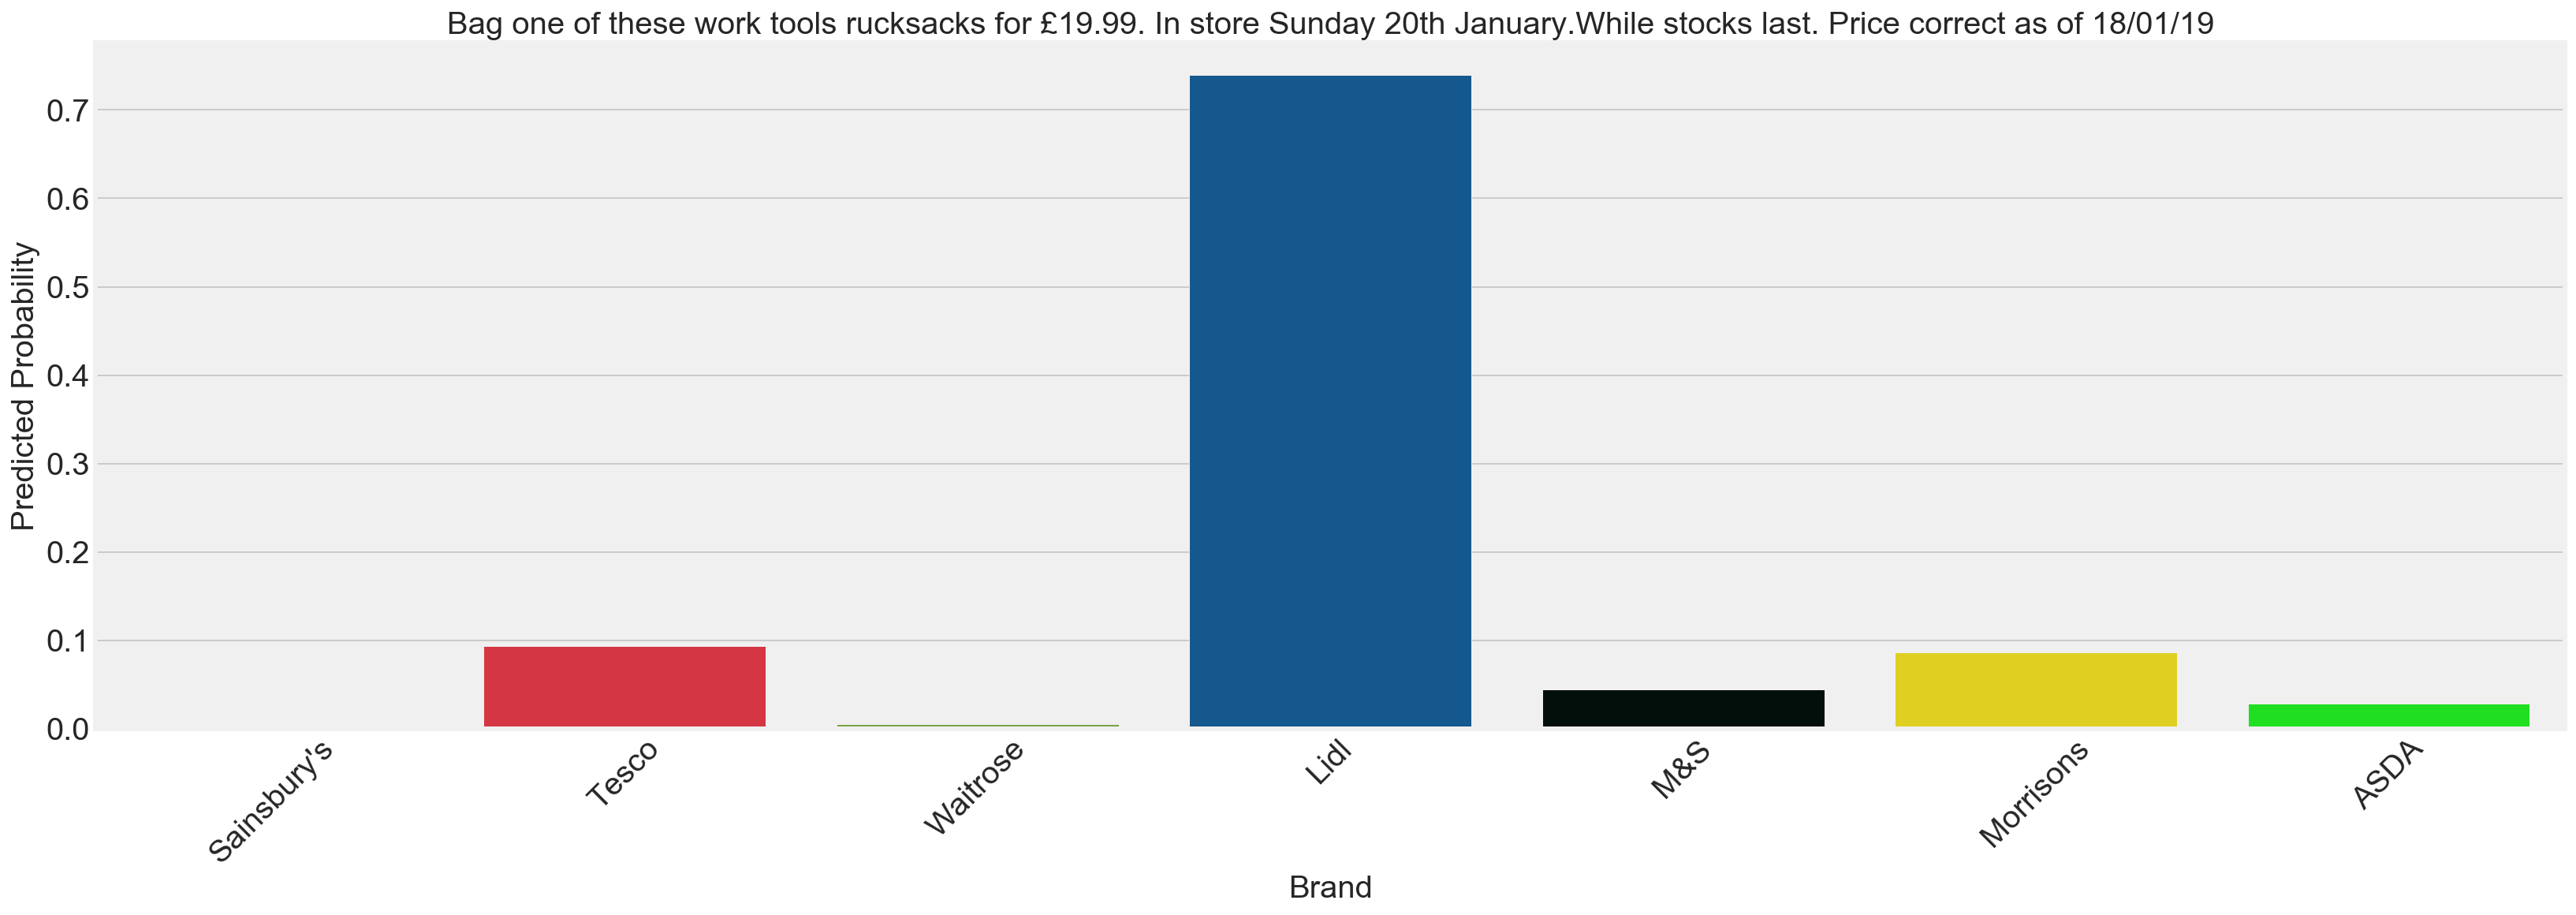

In [26]:
prob_plotter("Bag one of these work tools rucksacks for £19.99. In store Sunday 20th January.While stocks last. Price correct as of 18/01/19")

<img src="Assets/unseen_waitrose.png" style="width: 350px;">

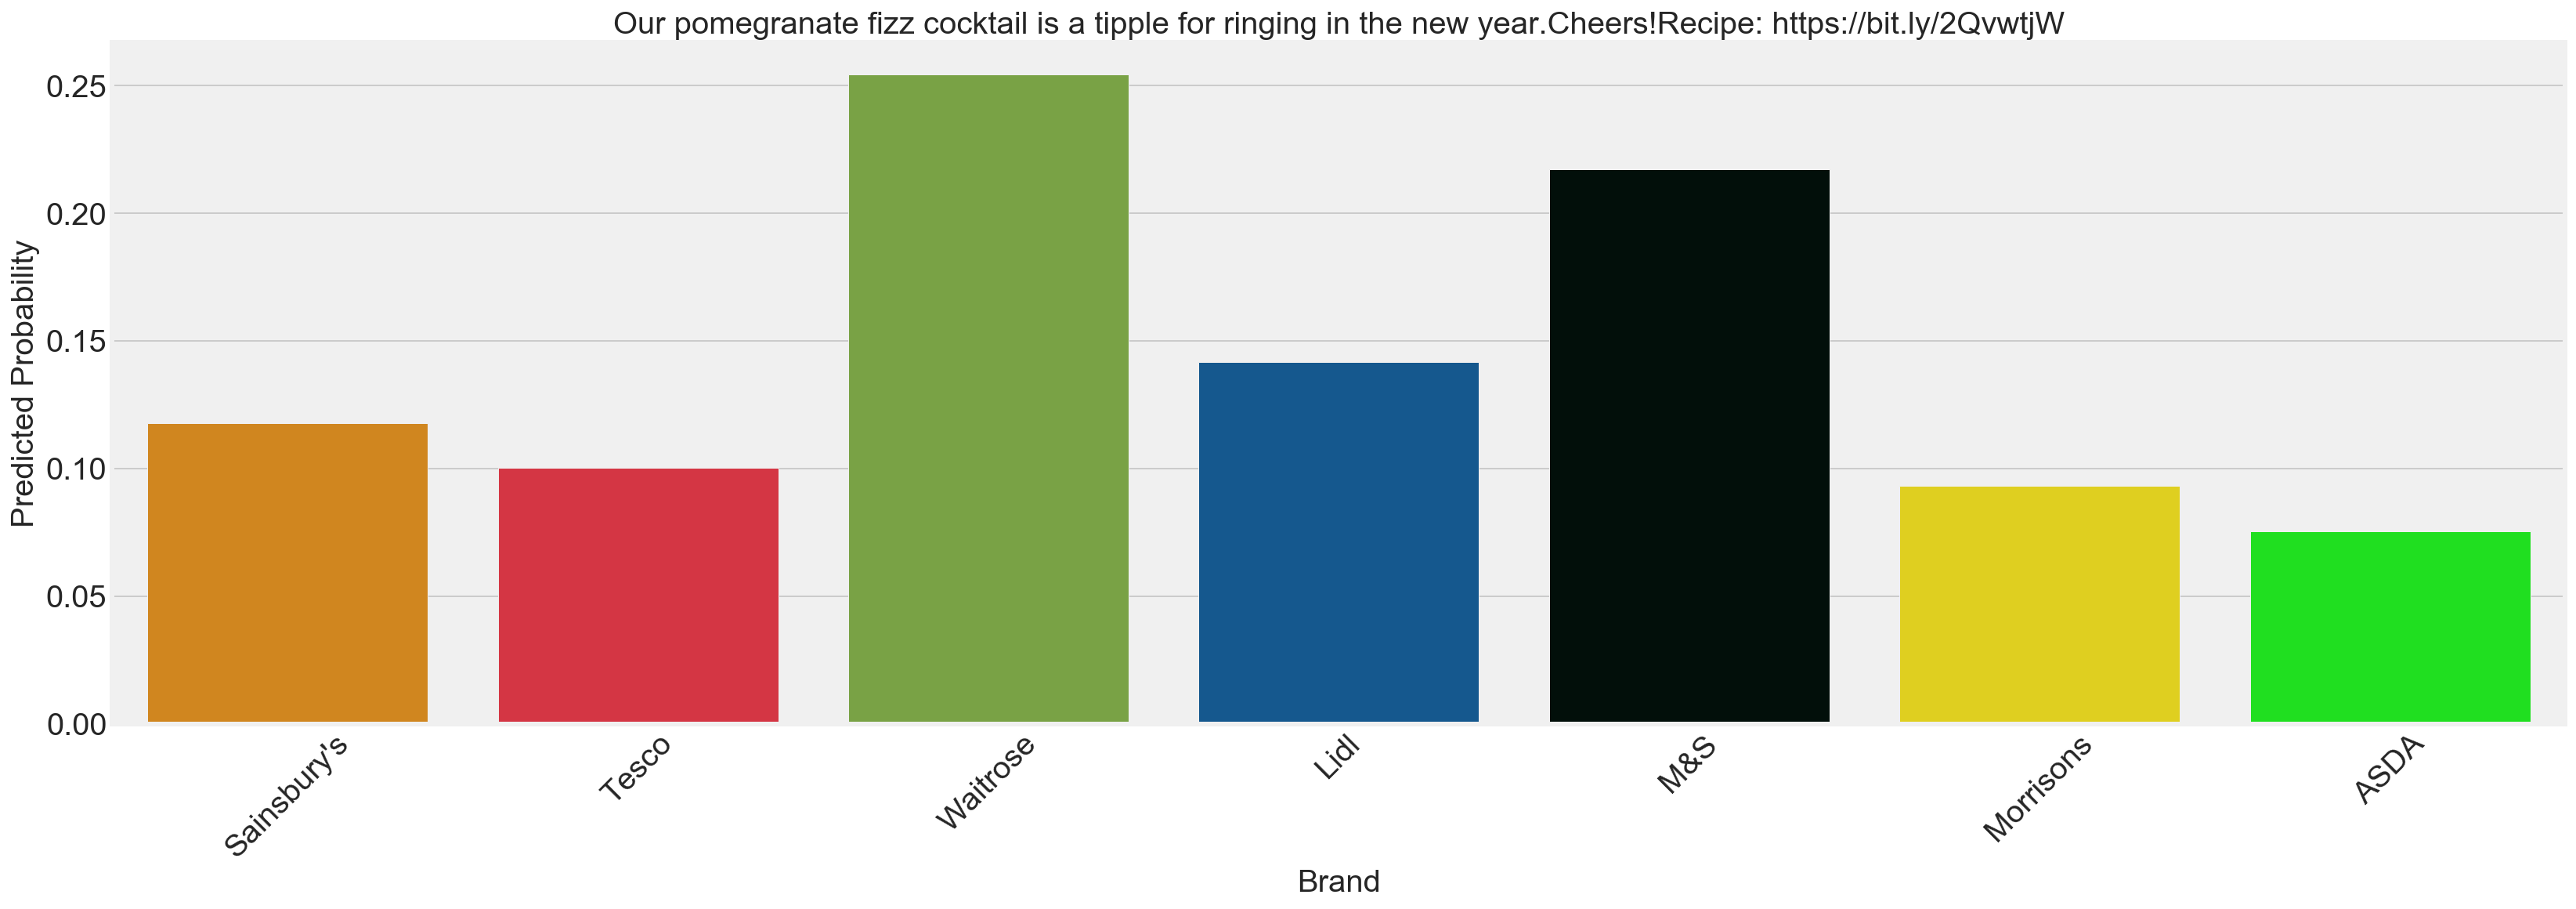

In [27]:
#it works!
prob_plotter("Our pomegranate fizz cocktail is a tipple for ringing in the new year.Cheers!Recipe: https://bit.ly/2QvwtjW")

<img src="Assets/unseen_sainsburys.png" style="width: 350px;">

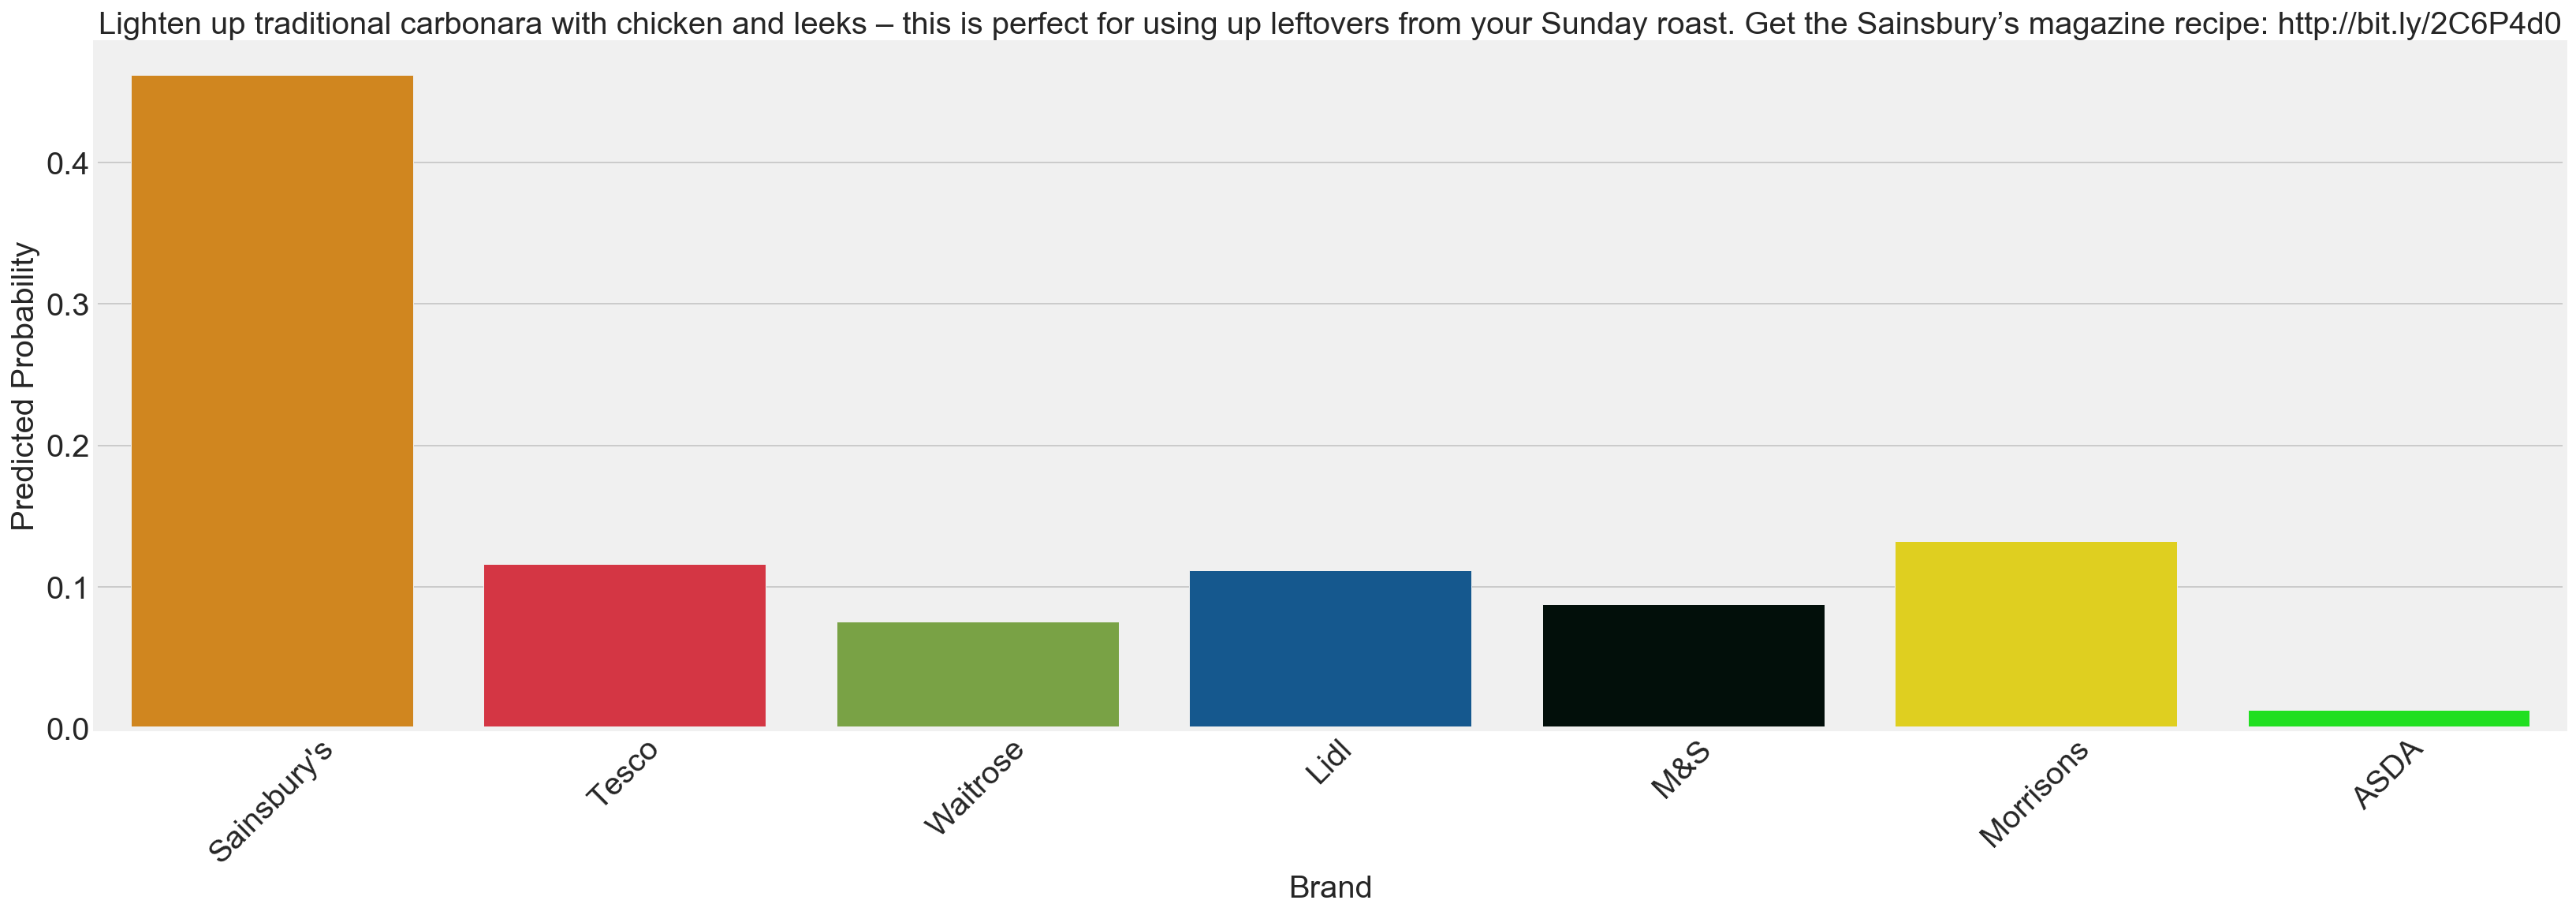

In [28]:
#it works!
prob_plotter("Lighten up traditional carbonara with chicken and leeks – this is perfect for using up leftovers from your Sunday roast. Get the Sainsbury’s magazine recipe: http://bit.ly/2C6P4d0")

<img src="Assets/unseen_asda.png" style="width: 350px;">

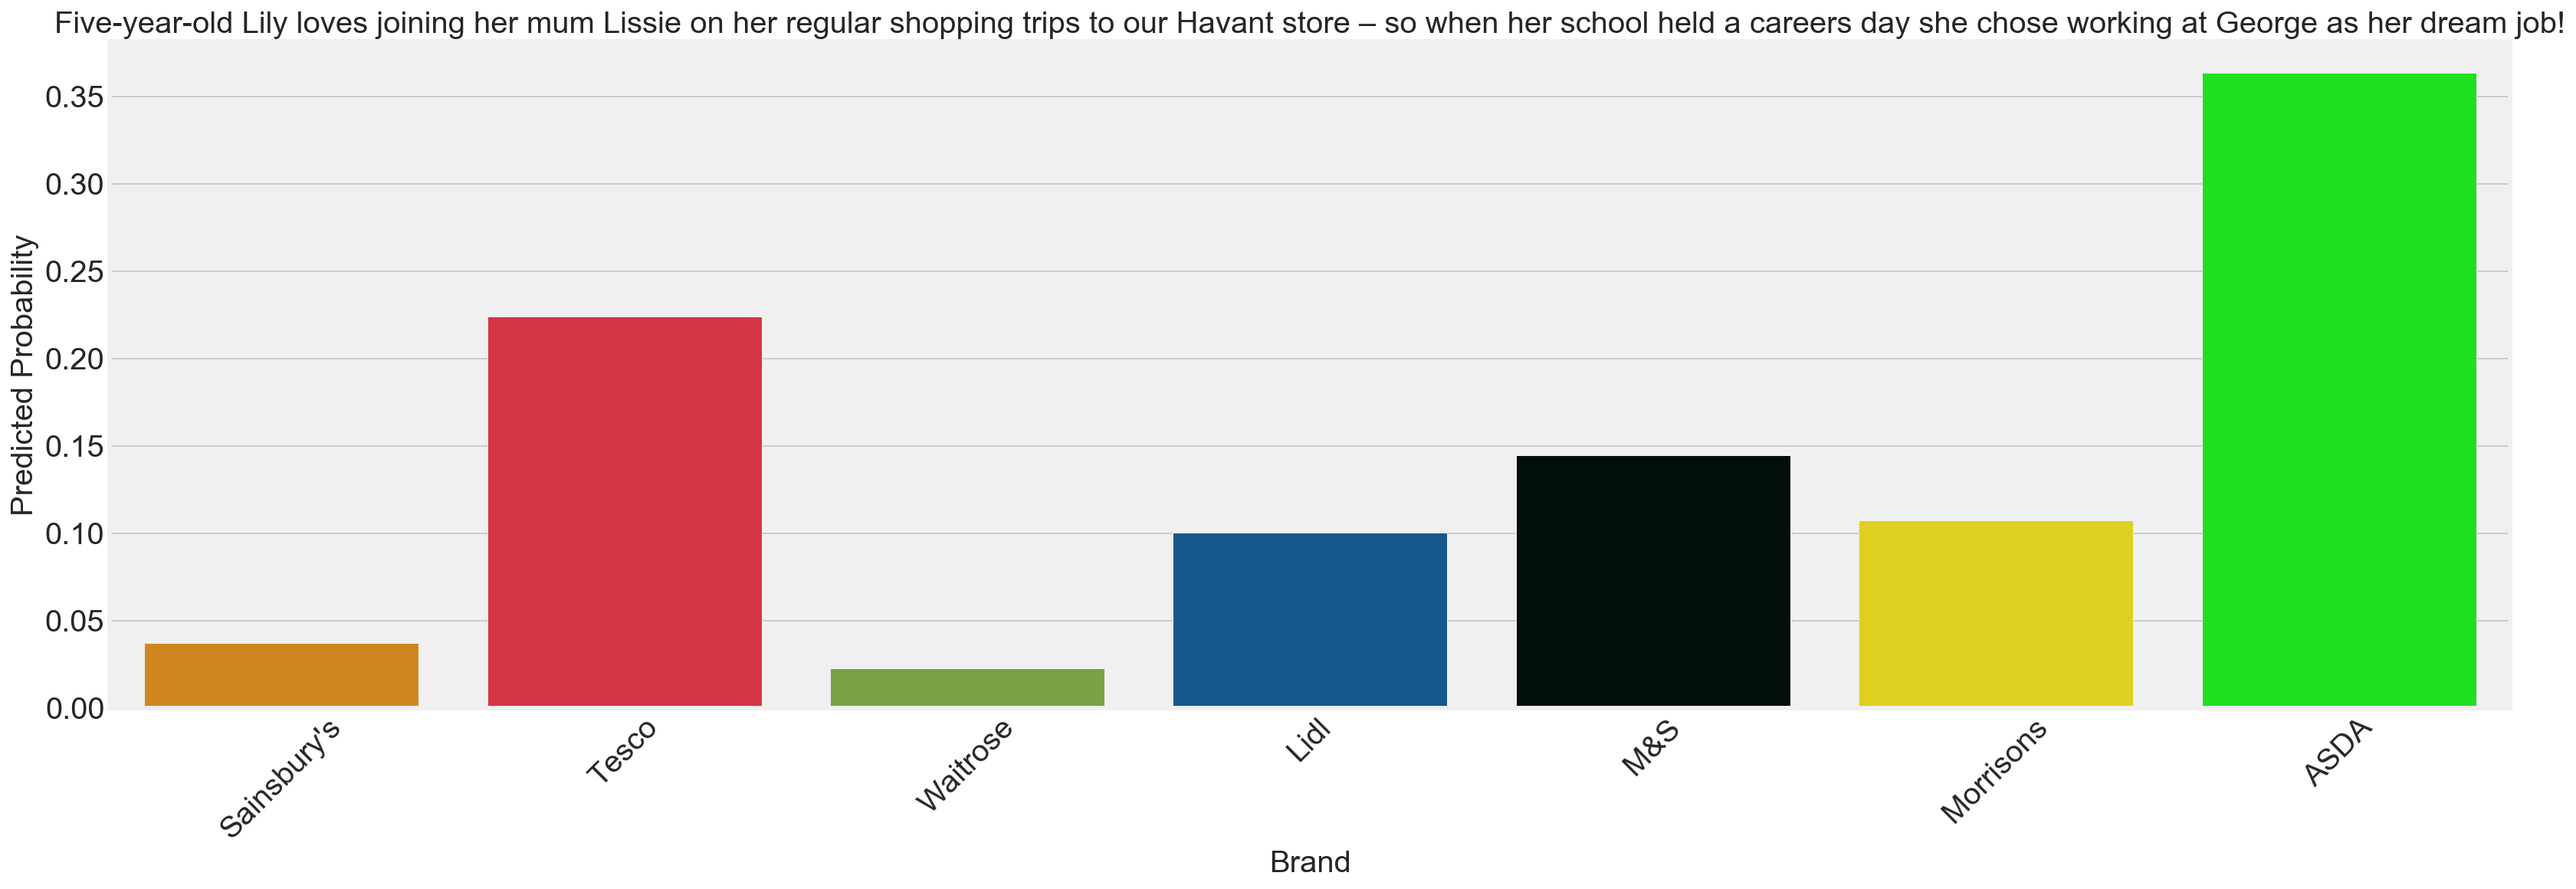

In [84]:
prob_plotter("Five-year-old Lily loves joining her mum Lissie on her regular shopping trips to our Havant store – so when her school held a careers day she chose working at George as her dream job!")

<img src="Assets/unseen_morrisons.png" style="width: 350px;">

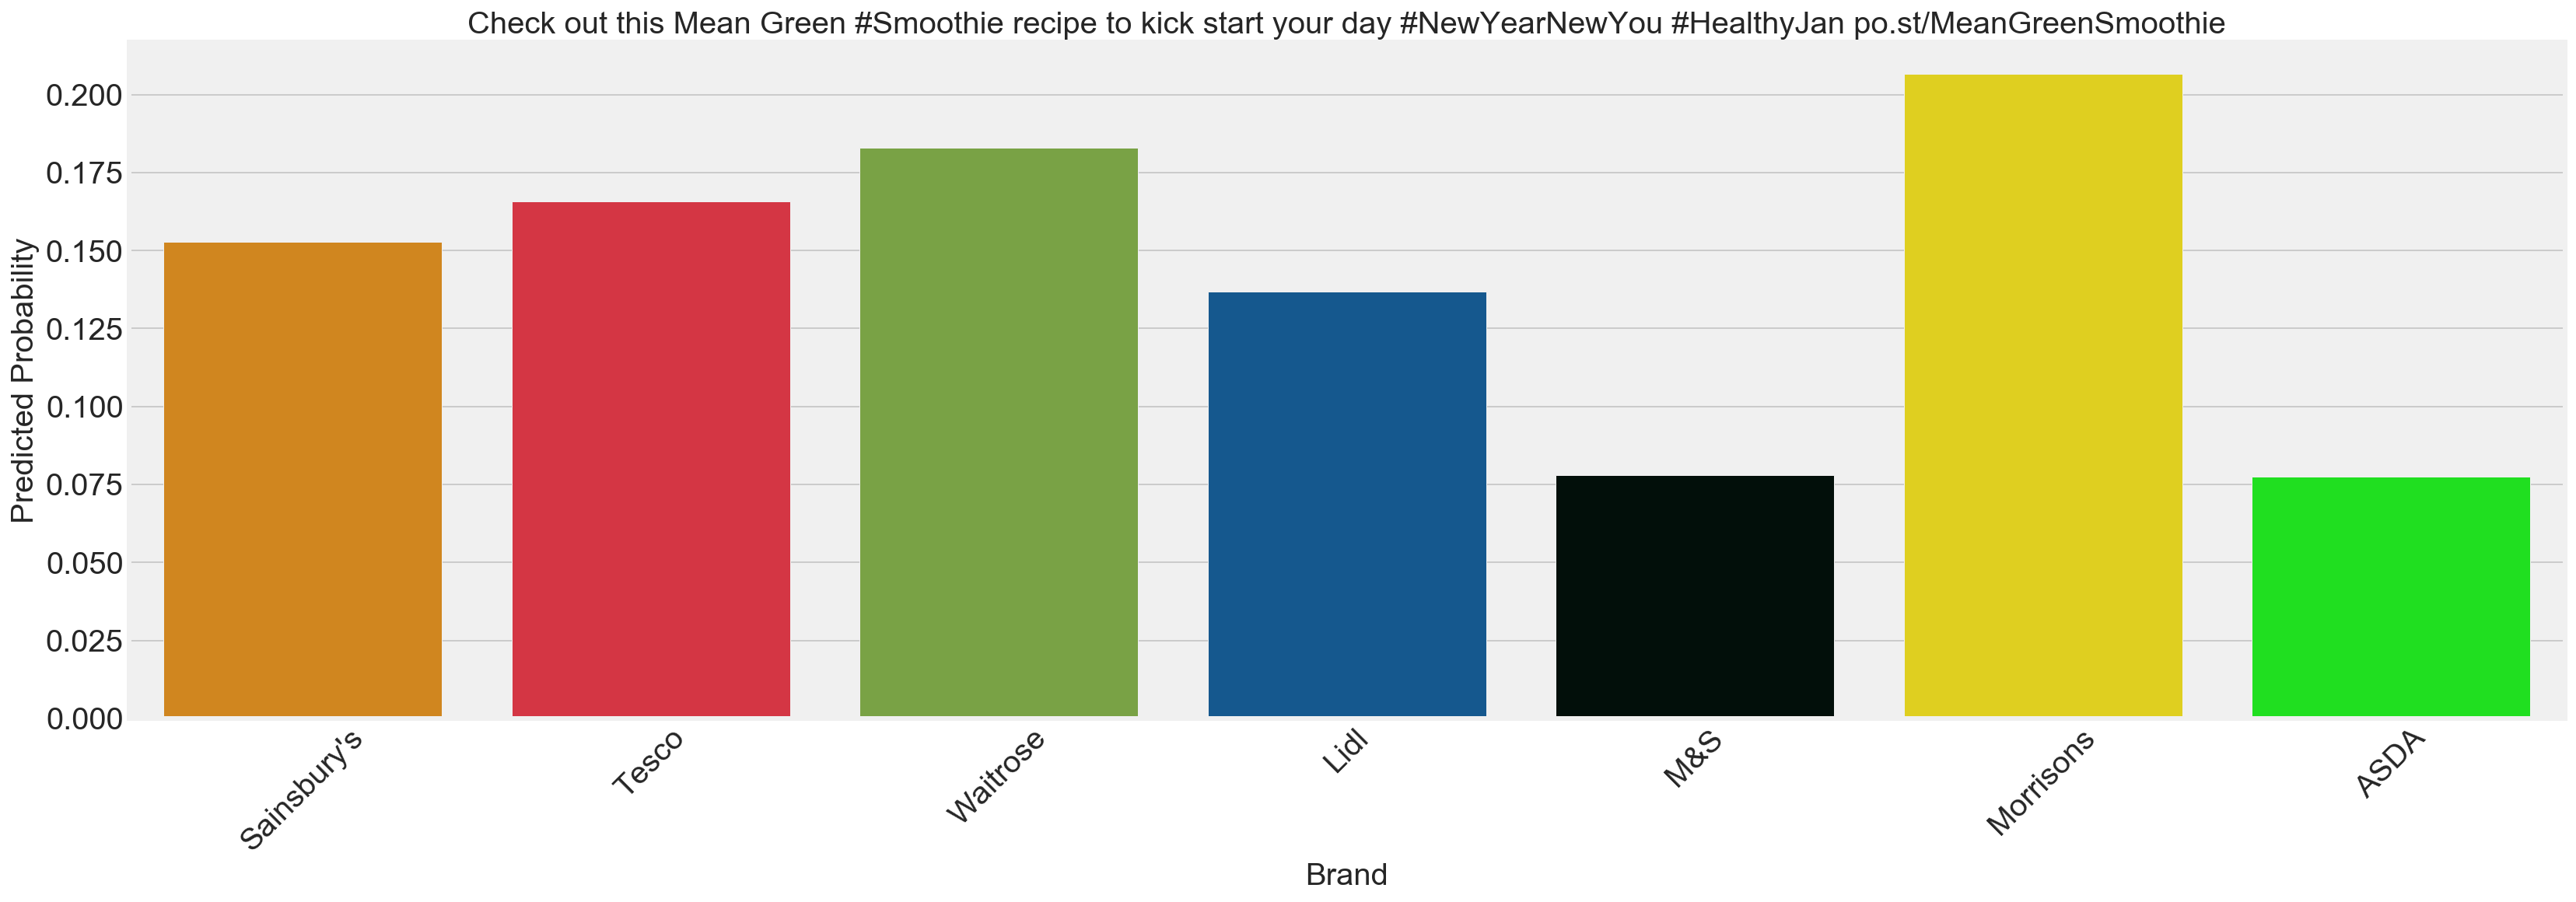

In [85]:
prob_plotter("Check out this Mean Green #Smoothie recipe to kick start your day #NewYearNewYou #HealthyJan po.st/MeanGreenSmoothie")

<a id="finalconfusion"></a>
## `Evaluating the final model - Confusion Matrix / Classification Report`
---
      

In [56]:
green = sns.light_palette("pink", as_cmap=True)
docm(y_test,eclf2.predict(X_test),y_labels).style.background_gradient(cmap=green)

,p_Sainsbury's,p_Tesco,p_Waitrose,p_Lidl,p_M&S,p_Morrisons,p_ASDA
Sainsbury's,111,19,5,23,11,8,1
Tesco,5,189,7,30,17,13,6
Waitrose,0,22,147,11,7,6,1
Lidl,9,42,4,246,23,6,8
M&S,3,33,3,23,135,19,2
Morrisons,1,20,2,10,8,153,6
ASDA,3,27,2,8,9,14,130


<a id="roc"></a>
## `Evaluating the final model - ROC`
---
      